In [1]:
# Import necessary libraries
import os

# Create a directory to store the datasets
os.makedirs('datasets', exist_ok=True)

# Define the URLs for the datasets
train_url = "https://www.dropbox.com/scl/fi/ghja3vpc34k78cg89uwjq/test.ft.txt?rlkey=e6rd56dtbv2ypms57m1l76brm&st=plgg4bhb&dl=0"
test_url = "https://www.dropbox.com/scl/fi/iof2u1j31x5ffoytg2du5/train.ft.txt?rlkey=4xld1u112j0gogam297xajqg2&st=yjvlyblz&dl=0"

# Use wget to download the files
!wget -O datasets/train.ft.txt {train_url}
!wget -O datasets/test.ft.txt {test_url}

# Verify the files are downloaded
!ls datasets


--2024-08-06 06:13:40--  https://www.dropbox.com/scl/fi/ghja3vpc34k78cg89uwjq/test.ft.txt?rlkey=e6rd56dtbv2ypms57m1l76brm
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4db22cccaabdaaf14aab6f8c32.dl.dropboxusercontent.com/cd/0/inline/CYEmWbFa7gh_h0KwmMB34jazHq--Af08NgoJReyXAarIsa7TKxnlXy7YPZWnGr33ucIUdIPa8VbhezvpzVeA9d7RO47B6vnF_cpyCw5OATqqN91YoVglAaTWaeFecF53pObgR9n-3UQMKjY7YoSlSMAS/file# [following]
--2024-08-06 06:13:41--  https://uc4db22cccaabdaaf14aab6f8c32.dl.dropboxusercontent.com/cd/0/inline/CYEmWbFa7gh_h0KwmMB34jazHq--Af08NgoJReyXAarIsa7TKxnlXy7YPZWnGr33ucIUdIPa8VbhezvpzVeA9d7RO47B6vnF_cpyCw5OATqqN91YoVglAaTWaeFecF53pObgR9n-3UQMKjY7YoSlSMAS/file
Resolving uc4db22cccaabdaaf14aab6f8c32.dl.dropboxusercontent.com (uc4db22cccaabdaaf14aab6f8c32.dl.dropboxusercontent.com)... 162.125.1.15, 2620:10

In [2]:
# Import necessary libraries
import os
import time
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, get_linear_schedule_with_warmup


In [3]:
# Import necessary library for train_test_split
from sklearn.model_selection import train_test_split

# Reading data
start_time = time.time()
with open("datasets/train.ft.txt", 'r', encoding='utf-8') as file:
    train = file.readlines()

with open("datasets/test.ft.txt", 'r', encoding='utf-8') as file:
    test = file.readlines()
data_reading_time = time.time() - start_time

# Processing training data
start_time = time.time()
train_labels = []
train_reviews = []

for line in train:
    if line.startswith("__label__"):
        label = int(line.split(' ')[0].replace('__label__', '').strip())
        review = ' '.join(line.split(' ')[1:]).strip()
        train_labels.append(label)
        train_reviews.append(review)

# Convert labels to 0 and 1
train_labels = [label - 1 for label in train_labels]  # Convert 1 to 0 and 2 to 1

# Processing test data
test_labels = []
test_reviews = []

for line in test:
    if line.startswith("__label__"):
        label = int(line.split(' ')[0].replace('__label__', '').strip())
        review = ' '.join(line.split(' ')[1:]).strip()
        test_labels.append(label)
        test_reviews.append(review)

# Convert labels to 0 and 1
test_labels = [label - 1 for label in test_labels]  # Convert 1 to 0 and 2 to 1

data_processing_time = time.time() - start_time

# Creating DataFrames
start_time = time.time()
train_df = pd.DataFrame({
    'review': train_reviews,
    'label': train_labels
})

test_df = pd.DataFrame({
    'review': test_reviews,
    'label': test_labels
})

# Splitting data into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
dataframe_creation_time = time.time() - start_time


In [4]:
# Training function for GPT-2
def train_epoch(model, data_loader, optimizer, device, scheduler, accumulation_steps):
    model = model.train()
    total_loss = 0

    optimizer.zero_grad()

    for i, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

    return total_loss / len(data_loader)

# Validation function for GPT-2
def eval_model(model, data_loader, device):
    model = model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

    return total_loss / len(data_loader)


In [5]:
# Loading GPT-2 tokenizer
start_time = time.time()
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token  # Set the pad token to eos token for GPT-2
gpt2_tokenizer_loading_time = time.time() - start_time

class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = self.reviews[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Creating datasets for GPT-2
print("Creating datasets for GPT-2...")
start_time = time.time()
gpt2_train_dataset = ReviewsDataset(
    reviews=train_df.review.to_numpy(),
    labels=train_df.label.to_numpy(),
    tokenizer=gpt2_tokenizer,
    max_len=128  # Max length for GPT-2
)

gpt2_val_dataset = ReviewsDataset(
    reviews=val_df.review.to_numpy(),
    labels=val_df.label.to_numpy(),
    tokenizer=gpt2_tokenizer,
    max_len=128
)

gpt2_test_dataset = ReviewsDataset(
    reviews=test_df.review.to_numpy(),
    labels=test_df.label.to_numpy(),
    tokenizer=gpt2_tokenizer,
    max_len=128
)
gpt2_dataset_creation_time = time.time() - start_time

# Creating data loaders for GPT-2
print("Creating data loaders for GPT-2...")
start_time = time.time()
batch_size = 16
gpt2_train_loader = DataLoader(gpt2_train_dataset, batch_size=batch_size, shuffle=True)
gpt2_val_loader = DataLoader(gpt2_val_dataset, batch_size=batch_size)
gpt2_test_loader = DataLoader(gpt2_test_dataset, batch_size=batch_size)
gpt2_data_loader_creation_time = time.time() - start_time

# Load pre-trained GPT-2 model
print("Loading pre-trained GPT-2 model...")
start_time = time.time()
gpt2_model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
gpt2_model.config.pad_token_id = gpt2_tokenizer.pad_token_id
gpt2_model_loading_time = time.time() - start_time

# Unfreezing the last two layers for GPT-2
for param in gpt2_model.transformer.parameters():
    param.requires_grad = False

for param in gpt2_model.transformer.h[-2:].parameters():
    param.requires_grad = True

# Set up optimizer and scheduler for GPT-2
gpt2_optimizer = AdamW(gpt2_model.parameters(), lr=2e-5)
gpt2_total_steps = len(gpt2_train_loader) * 3  # Assuming 3 epochs
gpt2_scheduler = get_linear_schedule_with_warmup(
    gpt2_optimizer,
    num_warmup_steps=0,
    num_training_steps=gpt2_total_steps
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Creating datasets for GPT-2...
Creating data loaders for GPT-2...
Loading pre-trained GPT-2 model...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training the GPT-2 model
gpt2_model = gpt2_model.to(device)

# Define the accumulation steps
accumulation_steps = 4

print("Starting GPT-2 training...")
EPOCHS = 3
gpt2_epoch_times = []
for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    train_loss = train_epoch(gpt2_model, gpt2_train_loader, gpt2_optimizer, device, gpt2_scheduler, accumulation_steps)
    val_loss = eval_model(gpt2_model, gpt2_val_loader, device)
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    gpt2_epoch_times.append(epoch_duration)

    print(f'GPT-2 Epoch {epoch + 1}/{EPOCHS} completed in {epoch_duration:.2f} seconds.')
    print(f'GPT-2 Train loss: {train_loss}')
    print(f'GPT-2 Val loss: {val_loss}')

# Save the GPT-2 model
print("Saving the GPT-2 model...")
start_time = time.time()
gpt2_model.save_pretrained("saved_model_gpt2")
gpt2_tokenizer.save_pretrained("saved_model_gpt2")
gpt2_model_saving_time = time.time() - start_time
print(f"GPT-2 Model saved in {gpt2_model_saving_time:.2f} seconds.")


Using device: cuda
Starting GPT-2 training...
GPT-2 Epoch 1/3 completed in 3748.68 seconds.
GPT-2 Train loss: 0.2515049820793327
GPT-2 Val loss: 0.17256409717714413
GPT-2 Epoch 2/3 completed in 3729.33 seconds.
GPT-2 Train loss: 0.18508079172021244
GPT-2 Val loss: 0.15785225179167464
GPT-2 Epoch 3/3 completed in 3724.67 seconds.
GPT-2 Train loss: 0.1702930274440674
GPT-2 Val loss: 0.15080639324071818
Saving the GPT-2 model...
GPT-2 Model saved in 11.29 seconds.


In [9]:
import torch
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from torch.utils.data import Subset, DataLoader

# Function to get predictions for GPT-2
def get_predictions(model, data_loader, device):
    model = model.eval()
    reviews = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs.logits, dim=1)

            reviews.extend(batch['review_text'])
            predictions.extend(preds)
            prediction_probs.extend(outputs.logits)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    return reviews, predictions, prediction_probs, real_values

# Evaluate the GPT-2 model
print("Evaluating the GPT-2 model...")
start_time = time.time()
y_val_review_texts, y_val_pred, y_val_pred_probs, y_val_test = get_predictions(
    gpt2_model,
    gpt2_val_loader,
    device
)
gpt2_val_predictions_time = time.time() - start_time
print(f'GPT-2 Validation predictions completed in {gpt2_val_predictions_time:.2f} seconds.')
print('GPT-2 Validation Classification Report:')
print(classification_report(y_val_test, y_val_pred))
print('GPT-2 Validation Accuracy:', accuracy_score(y_val_test, y_val_pred))

# Randomly select 30% of the test dataset
test_indices = np.random.choice(len(gpt2_test_dataset), size=int(0.3 * len(gpt2_test_dataset)), replace=False)
test_subset = Subset(gpt2_test_dataset, test_indices)
test_loader_30 = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Get predictions for the 30% test subset
start_time = time.time()
y_test_review_texts, y_test_pred, y_test_pred_probs, y_test_labels = get_predictions(
    gpt2_model,
    test_loader_30,
    device
)
test_predictions_time = time.time() - start_time
print(f'Test predictions completed in {test_predictions_time:.2f} seconds.')
print('Test Classification Report:')
print(classification_report(y_test_labels, y_test_pred))
print('Test Accuracy:', accuracy_score(y_test_labels, y_test_pred))


Evaluating the GPT-2 model...
GPT-2 Validation predictions completed in 575.27 seconds.
GPT-2 Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     39896
           1       0.94      0.94      0.94     40104

    accuracy                           0.94     80000
   macro avg       0.94      0.94      0.94     80000
weighted avg       0.94      0.94      0.94     80000

GPT-2 Validation Accuracy: 0.9437
Test predictions completed in 7766.64 seconds.
Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94    539768
           1       0.95      0.94      0.94    540232

    accuracy                           0.94   1080000
   macro avg       0.94      0.94      0.94   1080000
weighted avg       0.94      0.94      0.94   1080000

Test Accuracy: 0.9444435185185185


Generating confusion matrix for validation set...


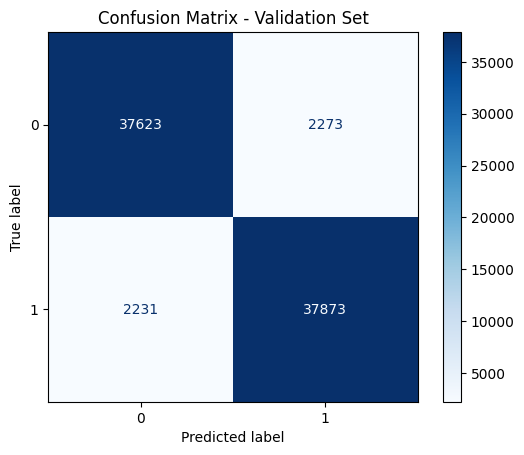

Generating confusion matrix for test set...


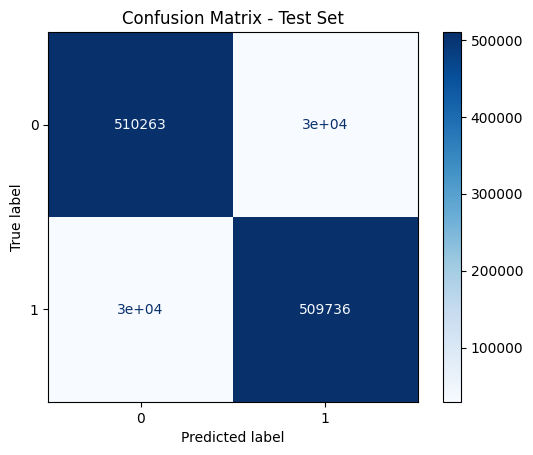

Generating precision-recall curve for validation set...


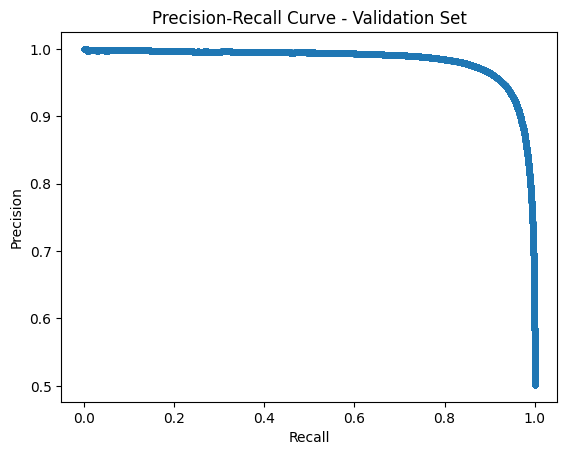

Generating ROC curve for validation set...


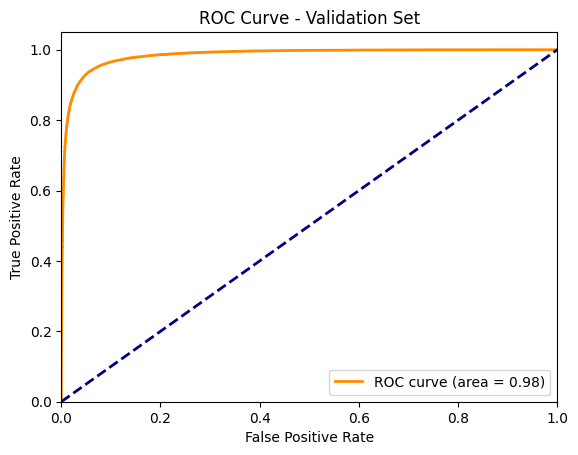

Generating precision-recall curve for test set...


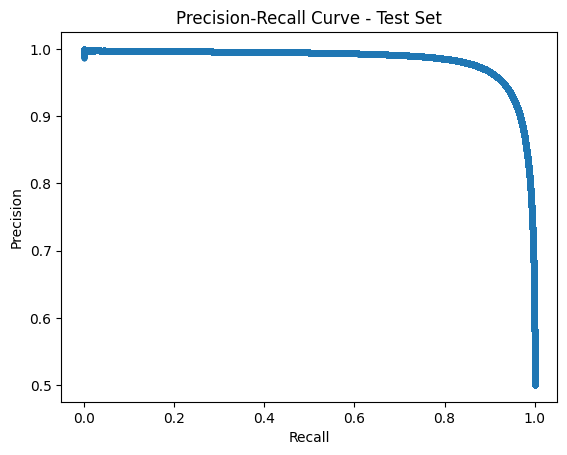

Generating ROC curve for test set...


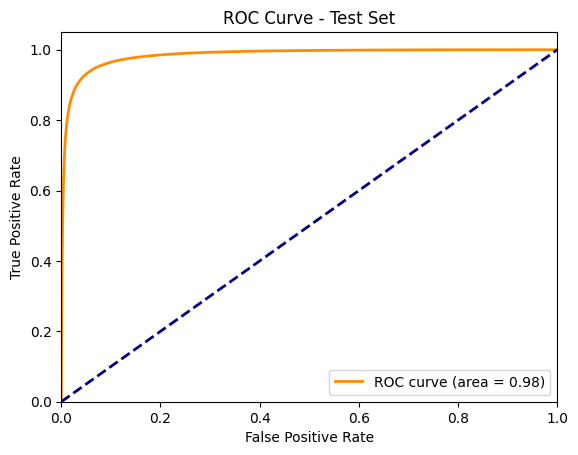

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc

# Generate confusion matrix for validation set
print("Generating confusion matrix for validation set...")
cm_val = confusion_matrix(y_val_test, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

# Generate confusion matrix for test set
print("Generating confusion matrix for test set...")
cm_test = confusion_matrix(y_test_labels, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

# Function to plot precision-recall curve
def plot_precision_recall(y_true, y_pred_probs, title="Precision-Recall Curve"):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs[:, 1])
    plt.figure()
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_probs, title="Receiver Operating Characteristic"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot precision-recall curve for validation set
print("Generating precision-recall curve for validation set...")
plot_precision_recall(y_val_test, y_val_pred_probs, title="Precision-Recall Curve - Validation Set")

# Plot ROC curve for validation set
print("Generating ROC curve for validation set...")
plot_roc_curve(y_val_test, y_val_pred_probs, title="ROC Curve - Validation Set")

# Plot precision-recall curve for test set
print("Generating precision-recall curve for test set...")
plot_precision_recall(y_test_labels, y_test_pred_probs, title="Precision-Recall Curve - Test Set")

# Plot ROC curve for test set
print("Generating ROC curve for test set...")
plot_roc_curve(y_test_labels, y_test_pred_probs, title="ROC Curve - Test Set")


In [11]:
import pandas as pd
import numpy as np

# Get the indices where the model made mistakes for the validation set
val_mistakes_indices = np.where(y_val_test != y_val_pred)[0]

# Extract the corresponding reviews and true/predicted labels for validation set
val_mistakes = {
    'review_text': [y_val_review_texts[i] for i in val_mistakes_indices],
    'true_label': [y_val_test[i].item() for i in val_mistakes_indices],
    'predicted_label': [y_val_pred[i].item() for i in val_mistakes_indices]
}

# Convert to DataFrame
val_mistakes_df = pd.DataFrame(val_mistakes)

# Save to CSV
val_mistakes_df.to_csv('validation_mistakes.csv', index=False)
print("Validation mistakes saved to validation_mistakes.csv")

# Get the indices where the model made mistakes for the test set
test_mistakes_indices = np.where(y_test_labels != y_test_pred)[0]

# Extract the corresponding reviews and true/predicted labels for test set
test_mistakes = {
    'review_text': [y_test_review_texts[i] for i in test_mistakes_indices],
    'true_label': [y_test_labels[i].item() for i in test_mistakes_indices],
    'predicted_label': [y_test_pred[i].item() for i in test_mistakes_indices]
}

# Convert to DataFrame
test_mistakes_df = pd.DataFrame(test_mistakes)

# Save to CSV
test_mistakes_df.to_csv('test_mistakes.csv', index=False)
print("Test mistakes saved to test_mistakes.csv")


Validation mistakes saved to validation_mistakes.csv
Test mistakes saved to test_mistakes.csv


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Validation Errors:
                                         review_text  true_label  \
0  second time's the charm: The first week after ...           1   
1  Works fine, but a little wobbly: It does not f...           1   
2  canera case: Great sturdy case for my sony cam...           0   
3  Caution on included batteries: I purchased six...           1   
4  Is there going to be a Director's Cut Version?...           1   

   predicted_label  
0                0  
1                0  
2                1  
3                0  
4                0  
        true_label  predicted_label
count  4504.000000      4504.000000
mean      0.495337         0.504663
std       0.500034         0.500034
min       0.000000         0.000000
25%       0.000000         0.000000
50%       0.000000         1.000000
75%       1.000000         1.000000
max       1.000000         1.000000

Test Errors:
                                         review_text  true_label  \
0  18- volt bulb: These fit my Craftsman

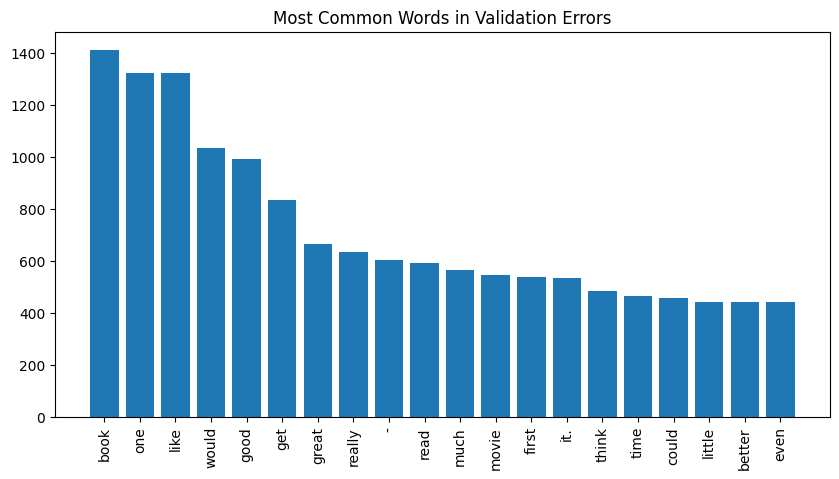

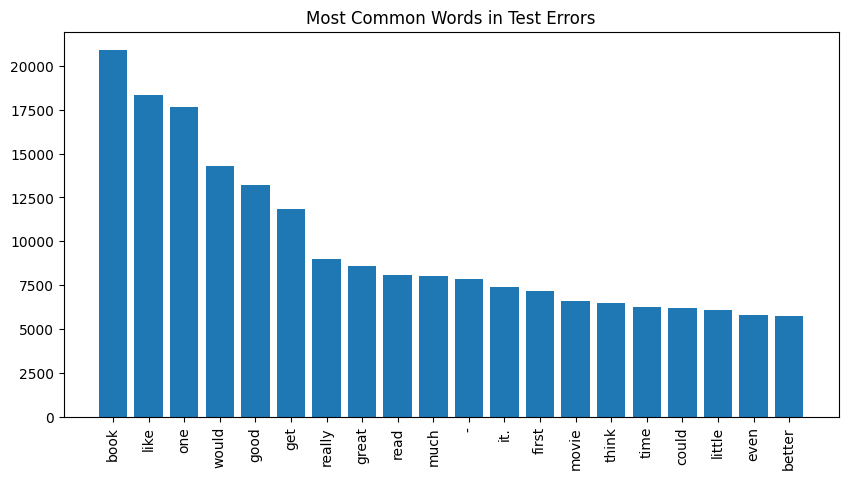

In [14]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

# Make sure to download the stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the CSV files
validation_errors = pd.read_csv('validation_mistakes.csv')
test_errors = pd.read_csv('test_mistakes.csv')

# Display basic information about the errors
print("Validation Errors:")
print(validation_errors.head())
print(validation_errors.describe())

print("\nTest Errors:")
print(test_errors.head())
print(test_errors.describe())

# Analyze the distribution of errors by true label
validation_error_distribution = validation_errors['true_label'].value_counts()
test_error_distribution = test_errors['true_label'].value_counts()

print("\nValidation Error Distribution by True Label:")
print(validation_error_distribution)

print("\nTest Error Distribution by True Label:")
print(test_error_distribution)

# Further analysis: most common words in the errors
def plot_common_words(dataframe, title):
    all_text = ' '.join(dataframe['review_text'].tolist())
    words = all_text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    word_counts = Counter(filtered_words)
    common_words = word_counts.most_common(20)

    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

plot_common_words(validation_errors, "Most Common Words in Validation Errors")
plot_common_words(test_errors, "Most Common Words in Test Errors")
